In [11]:
import pulp
import pandas as pd
import numpy as np

# Load data from Excel file
file_path = "BTP_database.xlsx"  # Change this to your actual file path
df = pd.read_excel(file_path)

# Define columns (Modify these based on your dataset)
input_columns = ["Cold Storage Equipments", "Healthcare Workforce", "Number of active cases", "Logistics Index", "Population"]
output_columns = ["Total Number of Vaccines", "Reduction in cases", "Equity distribution score"]

# Convert data to numpy arrays
inputs = df[input_columns].values
outputs = df[output_columns].values

n_dmus = len(df)  # Number of DMUs
n_inputs = len(input_columns)
n_outputs = len(output_columns)

# Define controllable & fixed subsets
Ic = [0, 1]  # Controllable inputs (Modify as needed)
If = [2, 3, 4]           # Fixed inputs
Oc = [0, 2]     # Controllable outputs
Of = [1]           # Fixed outputs

# Known global targets (Modify as needed)
global_input_targets = {0: 113850, 1: 1200 }  # Example targets
#global_output_targets = {0: 20114166, 2: 5.5 }  # Example target for coverage
global_output_targets = {0: 20114166 }
# Budget limit
#budget_limit = 100

# Preferences (Modify these weights as needed)
P_n_inputs = {0: 2, 1: 5 }
P_p_inputs = {0: -2, 1: -5 }
P_n_outputs = {0: -10, 2: -1}
P_p_outputs = {0: 10, 2: 1}
P_g_inputs = {0: 0, 1: 0}
P_g_outputs = {0: 1000}

# Budget-related subsets
#IB = [0, 1]  # Budget-relevant inputs
#OB = [0]     # Budget-relevant outputs

# Create the LP problem
prob = pulp.LpProblem("Goal_Programming_DEA_Model", pulp.LpMinimize)

# Decision variables for deviations (specific to DMU and input/output)
n_i = {(k, i): pulp.LpVariable(f"n_i_{k}_{i}", lowBound=0) for k in range(n_dmus) for i in Ic}
p_i = {(k, i): pulp.LpVariable(f"p_i_{k}_{i}", lowBound=0) for k in range(n_dmus) for i in Ic}
n_r = {(k, r): pulp.LpVariable(f"n_r_{k}_{r}", lowBound=0) for k in range(n_dmus) for r in Oc}
p_r = {(k, r): pulp.LpVariable(f"p_r_{k}_{r}", lowBound=0) for k in range(n_dmus) for r in Oc}

# Slack variables for global targets
d_i_plus = {i: pulp.LpVariable(f"d_i_plus_{i}", lowBound=0) for i in global_input_targets.keys()}
d_r_minus = {r: pulp.LpVariable(f"d_r_minus_{r}", lowBound=0) for r in global_output_targets.keys()}

# Decision variables for peer weights
delta = [[pulp.LpVariable(f"delta_{k}_{j}", lowBound=0) for j in range(n_dmus)] for k in range(n_dmus)]

# Global target variables
VXi = {i: pulp.LpVariable(f"VX_{i}", lowBound=0) for i in Ic if i not in global_input_targets}
VYr = {r: pulp.LpVariable(f"VY_{r}", lowBound=0) for r in Oc if r not in global_output_targets}

# Objective function: Minimize deviations and slacks
prob += (
    # Minimize deviations for controllable inputs
    pulp.lpSum((P_n_inputs[i] * n_i[k, i]) / inputs[k, i] + (P_p_inputs[i] * p_i[k, i]) / inputs[k, i]
               for k in range(n_dmus) for i in P_n_inputs.keys()) +
    # Minimize deviations for controllable outputs
    pulp.lpSum(P_n_outputs[r] * n_r[k, r] / outputs[k, r] + P_p_outputs[r] * p_r[k, r] / outputs[k, r]
               for k in range(n_dmus) for r in P_n_outputs.keys()) +
    # Minimize slack for global target inputs
    pulp.lpSum((P_g_inputs[i]*d_i_plus[i]) / global_input_targets[i] for i in global_input_targets.keys() ) +
    # Minimize slack for global target outputs
    pulp.lpSum((P_g_outputs[r]*d_r_minus[r]) / global_output_targets[r] for r in global_output_targets.keys() )
), "Objective_Function"

# Representation of individual DMUs
for k in range(n_dmus):
    # Controllable outputs
    for r in Oc:
            prob += (
                pulp.lpSum(delta[k][j] * outputs[j, r] for j in range(n_dmus)) - p_r[k, r] + n_r[k, r] == outputs[k, r]
            ), f"Controllable_Output_{r}_DMU_{k}"
    for r in Of:
            prob += (
                pulp.lpSum(delta[k][j] * outputs[j, r] for j in range(n_dmus)) >= outputs[k, r]
            ), f"Controllable_Output_{r}_DMU_{k}"


    # Controllable inputs
    for i in Ic:
            prob += (
                -pulp.lpSum(delta[k][j] * inputs[j, i] for j in range(n_dmus)) + p_i[k, i] - n_i[k, i] == -inputs[k, i]
            ), f"Controllable_Input_{i}_DMU_{k}"
    for i in If:
            prob += (
                -pulp.lpSum(delta[k][j] * inputs[j, i] for j in range(n_dmus)) >= -inputs[k, i]
            ), f"Controllable_Input_{i}_DMU_{k}"
# Effectiveness and global targets' achievement constraints
for i in Ic:
    if i in global_input_targets:
        prob += (
            -pulp.lpSum((delta[k][j] * inputs[j, i] for k in range(n_dmus)) for j in range(n_dmus)) + d_i_plus[i] == -global_input_targets[i]
        ), f"Global_Target_Input_{i}"
    elif i in VXi:
        prob += (
            -pulp.lpSum((delta[k][j] * inputs[j, i] for k in range(n_dmus)) for j in range(n_dmus)) + VXi[i] == 0
        ), f"Estimated_Global_Target_Input_{i}"

for r in Oc:
    if r in global_output_targets:
        prob += (
            pulp.lpSum((delta[k][j] * outputs[j, r] for k in range(n_dmus)) for j in range(n_dmus)) + d_r_minus[r] == global_output_targets[r]
        ), f"Global_Target_Output_{r}"
    elif r in VYr:
        prob += (
            pulp.lpSum((delta[k][j] * outputs[j, r] for k in range(n_dmus)) for j in range(n_dmus)) - VYr[r] == 0
        ), f"Estimated_Global_Target_Output_{r}"

# Budget balance constraint
#prob += (
   # pulp.lpSum((delta[k][j] * inputs[j, i] for k in range(n_dmus)) for j in range(n_dmus) for i in IB) -
   # pulp.lpSum((delta[k][j] * outputs[j, r] for k in range(n_dmus)) for j in range(n_dmus) for r in OB) <= budget_limit
#), "Budget_Balance"

# Extra constraints for non-negativity of variables
# Deviation variables for controllable inputs
for k in range(n_dmus):
    for i in Ic:
        prob += n_i[k, i] >= 0, f"NonNegativity_n_i_{k}_{i}"
        prob += p_i[k, i] >= 0, f"NonNegativity_p_i_{k}_{i}"

# Deviation variables for controllable outputs
for k in range(n_dmus):
    for r in Oc:
        prob += n_r[k, r] >= 0, f"NonNegativity_n_r_{k}_{r}"
        prob += p_r[k, r] >= 0, f"NonNegativity_p_r_{k}_{r}"

# Delta variables (peer weights)
for k in range(n_dmus):
    for j in range(n_dmus):
        prob += delta[k][j] >= 0, f"NonNegativity_Delta_{k}_{j}"

# Global target variables for inputs (VXi) and outputs (VYr)
for i in VXi.keys():
    prob += VXi[i] >= 0, f"NonNegativity_VXi_{i}"

for r in VYr.keys():
    prob += VYr[r] >= 0, f"NonNegativity_VYr_{r}"

# Slack variables for global targets
for i in global_input_targets.keys():
    prob += d_i_plus[i] >= 0, f"NonNegativity_d_i_plus_{i}"

for r in global_output_targets.keys():
    prob += d_r_minus[r] >= 0, f"NonNegativity_d_r_minus_{r}"


# Solve the LP problem
prob.solve()

# Display results
print("Status:", pulp.LpStatus[prob.status])
for v in prob.variables():
    print(f"{v.name} = {v.varValue}")



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_k/k8s6n7kj1vlchmtvlv_2jj_00000gn/T/43133caaa08549ada52aefca9c4d4c26-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/_k/k8s6n7kj1vlchmtvlv_2jj_00000gn/T/43133caaa08549ada52aefca9c4d4c26-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1393 COLUMNS
At line 13823 RHS
At line 15212 BOUNDS
At line 15213 ENDATA
Problem MODEL has 1388 rows, 1144 columns and 12188 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 243 (-1145) rows, 1141 (-3) columns and 10141 (-2047) elements
Perturbing problem by 0.001% of 203.22139 - largest nonzero change 1.9478904e-05 ( 0.00062019478%) - largest zero change 1.9452178e-05
0  Obj 0 Primal inf 4779.0184 (153) Dual inf 959.87734 (120)
0  Obj 0 Primal inf 4779.0184 (153) Du

In [16]:
# Calculate adjusted total vaccines for each DMU/state
adjusted_total_vaccines = []

for k in range(n_dmus):
    p_val = p_r[k, 0].varValue if p_r[k, 0].varValue is not None else 0
    n_val = n_r[k, 0].varValue if n_r[k, 0].varValue is not None else 0
    original_val = df.loc[k, "Total Number of Vaccines"]
    adjusted_val = original_val + p_val - n_val
    adjusted_total_vaccines.append(adjusted_val)

# Add the result as a new column to the dataframe
df["Adjusted Total Vaccines"] = adjusted_total_vaccines

# View the updated dataframe
print(df[["Total Number of Vaccines", "Adjusted Total Vaccines"]])


    Total Number of Vaccines  Adjusted Total Vaccines
0                     934240               934240.000
1                      36478                36478.000
2                     517414               517414.000
3                     651564               800083.460
4                     270967               615036.430
5                     374227               515438.050
6                      58425                36744.307
7                    1073598              1097831.108
8                     308278               625841.610
9                     278774               278774.000
10                    403772               332325.310
11                    165309               558015.850
12                   1087289              1173569.442
13                    736122               736122.000
14                    283267               879223.790
15                   2080998              2080998.000
16                     76881                29411.955
17                     86888

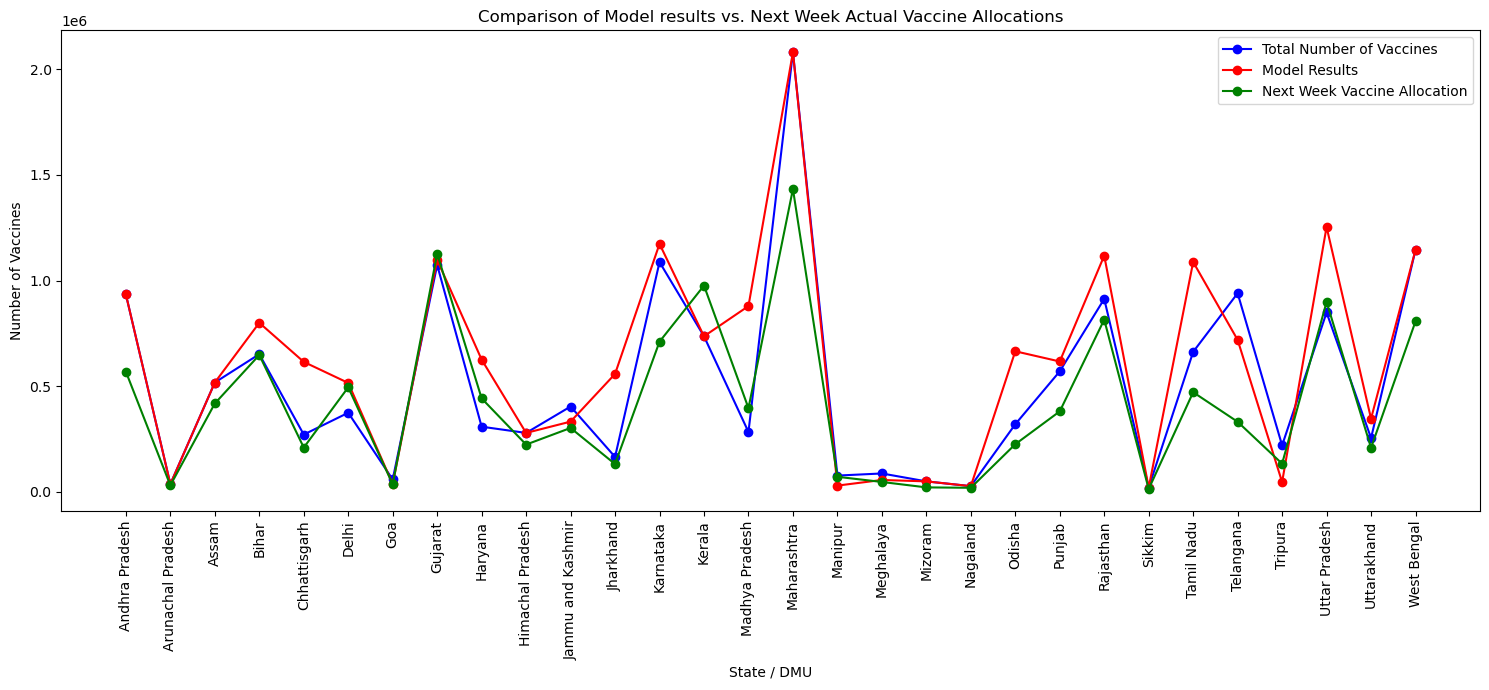

In [25]:
import matplotlib.pyplot as plt

# Provided actual next week's vaccine allocations (make sure they are in the correct order)
next_week_vaccines = [
    568691, 30639, 418094, 647662, 209463, 494679, 35815, 1127260, 442115, 223563,
    302310, 131444, 710692, 976224, 396122, 1433165, 71134, 46685, 20994, 19066,
    225302, 380779, 815084, 13339, 471441, 331485, 133191, 898746, 208387, 806844
]

# Add next week's vaccines to the dataframe
df["Next Week Actual"] = next_week_vaccines

# X-axis labels
states = df["State"] if "State" in df.columns else [f"DMU {i}" for i in range(len(df))]

# Plotting
plt.figure(figsize=(15, 7))

plt.plot(states, df["Total Number of Vaccines"], marker='o', color='blue', label='Total Number of Vaccines')

# Adjusted Total Vaccines (red)
plt.plot(states, df["Adjusted Total Vaccines"], marker='o', color='red', label='Model Results')

# Next Week Allocated Vaccines (green)
plt.plot(states, df["Next Week Actual"], marker='o', color='green', label='Next Week Vaccine Allocation')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Labels and title
plt.xlabel("State / DMU")
plt.ylabel("Number of Vaccines")
plt.title("Comparison of Model results vs. Next Week Actual Vaccine Allocations")
plt.legend()
plt.tight_layout()


plt.savefig("vaccine_comparison_graph.png", dpi=300)  # or .pdf, .jpgH
# Show the plot
plt.show()



In [21]:
efficient_dmus = []

for k in range(n_dmus):
    is_efficient = True
    for j in range(n_dmus):
        delta_val = delta[k][j].varValue if delta[k][j].varValue is not None else 0
        if j != k and delta_val > 1e-6:  # Allowing a tiny tolerance for numerical errors
            is_efficient = False
            break
    if is_efficient:
        efficient_dmus.append(k)

# Map to state names if available
if "State" in df.columns:
    efficient_states = df.loc[efficient_dmus, "State"].tolist()
else:
    efficient_states = [f"DMU {k}" for k in efficient_dmus]

print("Efficient States / DMUs:")
for state in efficient_states:
    print(state)


Efficient States / DMUs:
Andhra Pradesh
Arunachal Pradesh
Assam
Himachal Pradesh
Kerala
Maharashtra
Mizoram
Nagaland
Sikkim
West Bengal
